In [74]:
import json
import pickle
import numpy as np
import sys 
import xarray as xr
import matplotlib.pyplot as plt
sys.path.insert(0, "/gpfswork/rech/omr/uen17sn/NewSpinUp/lib")
import prepare

import importlib
importlib.reload(prepare)

<module 'prepare' from '/gpfswork/rech/omr/uen17sn/NewSpinUp/lib/prepare.py'>

In [75]:
#import importlib
#importlib.reload(prepare)

## **Load Data**

### 1.1 - Parameters

In [76]:
from simu_path import path13 
path       = path13                 #simupath
time_dim   = "time_counter"        #time axis : generaly "time_counter" or "time" 
grid_term  = ["zos.nc"]            #grid  #grid_T.nc... or feature "MSFT.nc","zos.nc"...  
simu_param = ["-"]                 #whatever distinguish the param/model used it when they are diff simu in same folder
simu_nb    = 113              
to_yearly  = False
cut_simu   = 25                    #currents = 0 take the stab year
pca_comp   = 0.9                   #if pca_comp < 1 explain ratio else nb of components taken
ssca       = False

if to_yearly==False: 
    cut_simu = cut_simu*12
                                                       #cut_simu      PCACOMP = 0.

### 1.2 - Load files

In [77]:
data = prepare.getData(path  = path,
                       term  = grid_term,
                       param = simu_param[0])

print(f"Nb of grid  :", len(data))
print(f"Nb of files :", len(data[grid_term[0]]))

Nb of grid  : 1
Nb of files : 2


In [78]:
data

{'zos.nc': ['/gpfsdsmnt/ipsl/dods/pub/ues27zx/IPSLCM6/DEVT/piControl/CM65Work-Spinup-Namelist-1/OCE/Analyse/TS_MO/CM65Work-Spinup-Namelist-1_18500101_19491231_1M_zos.nc',
  '/gpfsdsmnt/ipsl/dods/pub/ues27zx/IPSLCM6/DEVT/piControl/CM65Work-Spinup-Namelist-1/OCE/Analyse/TS_MO/CM65Work-Spinup-Namelist-1_19500101_20491231_1M_zos.nc']}

### 1.2 - Select features observing the file structure

In [79]:
grid           = grid_term[0]
d1,d3,d4,other = [],[],[],[]
dataset        = xr.open_dataset(data[grid][-1],decode_times=False)

for var in dataset.data_vars:
    dims  = dataset[var].dims
    name  = dataset[var].attrs.get('long_name',"NA")
    units = dataset[var].attrs.get('units',"NA")
    info  = f"{name}: {var} ({units}) - {dims}"
    if time_dim in dims:
        if len(dims)==1:
            d1.append((info))
        elif len(dims)==3:
            d3.append(info) 
        elif len(dims)==4:
            d4.append(info)
    else:
        other.append(info)
        
print(f"{grid}\n")
print(f"Simulation length: {dataset.sizes[time_dim]}\n")
print("1D var:")
for var in d1: print("   -",var)
print()
print("3D var:")
for var in d3: print("   -",var)
print()
print("4D var:")
for var in d4: print("   -",var)
print()
print("other:")
for var in other: print("   -",var)

zos.nc

Simulation length: 1200

1D var:

3D var:
   - sea_surface_height_above_geoid: zos (m) - ('time_counter', 'y', 'x')

4D var:

other:


In [80]:
var1D = []
var3D = ["zos"] #bbl is empty
#var4D = ["msftyz_glo"]
depth_dim  = "depthw"

## **Extract features**

### 2.1 - Extract 1D time series

In [81]:
dico1=None

In [82]:
#dico1 = toDictionnary(data["grid_U.nc"],"time_counter",1,var1D)

#print("Info of the simu    :",dico1.keys())
#print("\nNb of variables     :",len(dico1["features"].keys()))
#print("List of Variables   :",dico1["features"].keys())
#print("Duration of the simu:", dico1["features"][var3D[0]].shape[0])


### 2.2 - Extract 3D Features

In [83]:
#dico2 = None

dico2 = prepare.toDictionnary(grid     = data[grid],
                              dtime    = time_dim,    # !!! if to yearly change the coarsen function dimension !!!
                              nb_dim   = 3,
                              yearly   = to_yearly,
                              filter   = var3D,
                              cut_simu = cut_simu)  #unit depends on yearly = True or not


/linkhome/rech/genloc01/uen17sn/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [84]:
np.shape(dico2["features"]["zos"])

(2100, 331, 360)

In [85]:
#print("Info of the dico     :",dico2.keys())
#print("\nNb of variables     :",len(dico2["features"].keys()))
#print("List of Variables   :",dico2["features"].keys())
#print("Duration of the simu:", dico2["features"][var3D[0]].shape[0])

#print("\nFeatures infos:")
#for var in dico2["features"].keys():
#    print(f"   - {var} : {dico2['features'][var].shape}")

### 2.3 - Extract 4D features

In [86]:
dico3=None
#dico3 = prepare.toDictionnary(grid     = data[grid],
#                              dtime     = time_dim,
#                              nb_dim   = 4,
#                              filter   = var4D,
#                              yearly   = to_yearly,
#                              mean_dim = depth_dim,
#                              cut_simu = cut_simu,
#                              n_jobs   = 1)

In [87]:
#print("\nNb of variables     :",len(dico3["features"].keys()))
#print("List of Variables   :",dico3["features"].keys())
#print("Duration of the simu:", dico3["features"][var4D[0]].shape[0])

#print("\nFeatures infos:")
#for var in dico3["features"].keys():
#    print(f"   - {var} : {dico3['features'][var].shape}")


### 2.4 - Extract MSFT

def get_msft(path,velo,thickness,depth,yearly):
    file      = xr.open_dataset(path, chunks={"time_counter": 50},decode_times=False)
    to_delete = set(file.variables) - set([velo,thickness,depth])
    file      = file.drop_vars(to_delete)
    
    if yearly:
        file = file.coarsen(time_counter=12).mean().load() #TO CHANGE WITH TIME DIM
        
    velocity = file[velo] * file[thickness]
    velocity = velocity.sum(depth)
    msft     = np.array(velocity.cumsum(dim="y"))
    
    mask = np.isnan(file[velo][0,0].values)
    mask = np.broadcast_to(mask, msft.shape)
    msft = xr.where(mask, np.nan, msft)
    
    msft_dataset = xr.Dataset(
        {'MSFT': (['time_counter', 'y', 'x'], np.array(msft))},
        coords={
            'time_counter': file[velo].coords['time_counter'],
            'y': file[velo].coords['y'],
            'x': file[velo].coords['x']})
    file.close()
    return msft_dataset

def parallel_velo(grid,velo="uo",thickness="e3u",depth="depthu",ssca=True,yearly=True,cut_simu=10,n_jobs=1):
    ds = list(Parallel(n_jobs)(delayed(get_msft)(path,velo,thickness,depth,yearly) for path in grid))
    ds = xr.concat(ds, "time_counter")   
    var = "MSFT"
    return ds

In [88]:
#import joblib
#from joblib import Parallel, delayed, parallel_backend
#dico4 = parallel_velo(data[grid],
#                      ssca=ssca,
#                      yearly=to_yearly,
#                      cut_simu=cut_simu,
#                      n_jobs=2)

In [89]:
#ssca = prepare.getSSCA(test,["MSFT"])

In [90]:
#var = "MSFT"
#ds  = dico4

#features_dico,mean_dico,std_dico = {},{},{}
#ds[var].values[ds[var].values == 0.] = np.nan   
#ds[var] = ds[var].astype(np.float32) 
#mean    = ds.mean()
#std     = ds.std()
#ds[var] = (ds[var] - mean[var]) / (2*std[var])  
        
#features_dico[var] = ds[var].values
#mean_dico[var]     = mean[var].values
#std_dico[var]      = std[var].values


In [91]:
#msft_dico = {"features":features_dico,"mean":mean_dico,"std":std_dico} #"ssca":ssca

In [92]:
#msft_dico["features"]["MSFT"] = msft_dico["features"]["MSFT"][cut_simu:]

## **Transform to times series**

### 3.1 - Dico of 3D Features

In [93]:
prepare.toTimeSeries(simu   = dico2,
                     n_comp = pca_comp)


print("Info of the simu    :",dico2.keys())
print("\nFeatures infos:")
for var in dico2["features"].keys():
    print(f"   - {var} : {dico2['features'][var].shape}")

Info of the simu    : dict_keys(['features', 'mean', 'std', 'ssca', 'mask', 'pca'])

Features infos:
   - zos : (2100, 57)


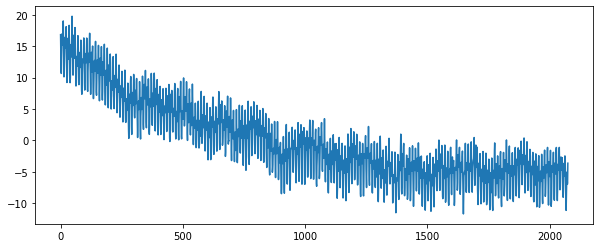

In [94]:
#should not observe effects of currents with cut simu
fig = plt.figure(figsize=(10,4))
plt.plot(np.array(dico2["features"]["zos"])[25:,0])

### 3.2 - Dico of 4D Features

In [95]:
#dico3 = prepare.toTimeSeries(simu   = dico3,
#                             n_comp = pca_comp)

#print("\nFeatures infos:")
#print("Info of the simu    :",dico3.keys())
#for var in dico3["features"].keys():
#    print(f"   - {var} : {dico3['features'][var].shape}")

## **Concatenate dictionnaries**

### 4.1 - Concatenate features

In [96]:
grids      = []
grid_dico  = {"features":{},"mean":{},"std":{},"ssca":{},"mask":{},"pca":{}}
dicos      = [dico2] #NO EMPTY DICO

grids.append(prepare.concatenateDico(dicos))

print("\nNb of variables     :",len(grids[0]["features"].keys()))
print("List of Variables   :",grids[0]["features"].keys())
print("Duration of the simu:", grids[0]["features"][var3D[0]].shape[0])
print("Info of the simu    :",grids[0].keys())

for var in grids[0]["features"].keys():
    print(f"   - {var} : {grids[0]['features'][var].shape}")


Nb of variables     : 1
List of Variables   : dict_keys(['zos'])
Duration of the simu: 2100
Info of the simu    : dict_keys(['features', 'mean', 'std', 'ssca', 'mask', 'pca'])
   - zos : (2100, 57)


### 4.2 - Concatenate grids

In [97]:
simu_dico = prepare.concatenateGrid(grids)

print("\nNb of variables     :",len(simu_dico["features"].keys()))
print("List of Variables   :",simu_dico["features"].keys())
print("Duration of the simu:", simu_dico["features"][var3D[0]].shape[0])
print("Info of the simu    :",simu_dico.keys())

for var in simu_dico["features"].keys():
    print(f"   - {var} : {simu_dico['features'][var].shape}")
    
print("Info of the ssca    :",simu_dico.keys())
for var in simu_dico["features"].keys():
    print(f"   - {var} : {simu_dico['ssca'][var].shape}")


Nb of variables     : 1
List of Variables   : dict_keys(['zos'])
Duration of the simu: 2100
Info of the simu    : dict_keys(['features', 'mean', 'std', 'ssca', 'mask', 'pca'])
   - zos : (2100, 57)
Info of the ssca    : dict_keys(['features', 'mean', 'std', 'ssca', 'mask', 'pca'])
   - zos : (12, 331, 360)


## **Save the simulation dictionnary**

In [98]:
prepare.saveSimu(dico   = simu_dico,
                 yearly = to_yearly,
                 n      = simu_nb)

you file where successfully saved in the dataset/monthly/pca and the dataset/monthly/simu folders
the number of the simulation is 113


___